In [1]:
from utils import load_dataset, load_texture_dataset, load_nci9

import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mutual_info_score, silhouette_score
from sklearn.cluster import KMeans


In [4]:
n_comp = 5
gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100)

data = load_dataset('landsat')
gmm.fit(data)

gmm_full = GaussianMixture(n_components=n_comp, covariance_type='tied', max_iter=100)
gmm_full.fit(data)

gmm.score(data), gmm_full.score(data)

kmeans = KMeans(n_clusters=n_comp)

kmeans.fit(data)


/home/skholkin/projects/python_venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [5]:
gmm.predict(data)
silhouette_score(data, gmm.predict(data)), silhouette_score(data, gmm_full.predict(data)), silhouette_score(data, kmeans.predict(data))

(0.44595330258613985, 0.4993138231480688, 0.4877439065553476)

In [6]:
gmm.score(data), gmm_full.score(data)

(39.10301174244565, 61.24189174817785)

## Write PSO for k means
## Abstract enougth to run PSO with GMM with sperical components and diagonal ones
## Try to get low variance of inertia/LL

In [7]:
from copy import deepcopy

class Particle:
    def __init__(self):
        self.state = None
        self.pb = None
        self.pb_score = -np.inf
        self.gb = None
    
    def step(self):
        pass
    
    def check_pb(self):
        if self.score() > self.pb_score:
            self.pb = self.copy()
    
    def score(self):
        pass

    def finetune(self):
        pass
    
    def set_gb(self, gb):
        self.gb = gb.copy()
        
    def mutation(self):
        raise NotImplementedError('Mutation is not implemented')
        
    
class PSO:
    def __init__(self, particles, n_steps):
        self.particles = particles
        self.n_steps = n_steps
        self.gb_particle, self.gb_score = None, -np.inf
        self.check_gb()
        
    def check_gb(self):
        for particle in self.particles:
            score = particle.score()
            if score > self.gb_score:
                self.gb_score = score
                self.gb_particle = particle.copy()
                
        gb = self.gb_particle.copy()
        for particle in self.particles:
            particle.set_gb(gb)
            
    def check_for_mutation(self):
        self.gb_score
        scores = []
        for i, particle in enumerate(self.particles):
            p_score = particle.score()
            scores.append(p_score)
            if np.absolute(p_score - self.gb_score) < 5e-2:
                particle.mutation()

        # to_mutate = np.argsort(scores)[: int(len(scores) / 5)]

        # for i, particle in enumerate(self.particles):
        #     if i in to_mutate:
        #         particle.mutation()
        
    def run(self):
        print(f'Init: gb ll {self.gb_score}')
        for step in range(self.n_steps):
            for i, particle in enumerate(self.particles):
                particle.step()
                particle.finetune()
                particle.check_pb()
#                 print(f'{i} score {particle.score()}')
#             print(f'Step {step} {[item.score() for item in self.particles]}')
            self.check_gb()
            self.check_for_mutation()
        
        print(f'Step {step}: gb ll {self.gb_score}')
        return self.gb_score


### For GMM with spherical components

In [3]:

    
class GMMSpherical(Particle):
    def __init__(self, data, n_comp, init_state, intertia, r_1, r_2):
        super(Particle, self).__init__()
        self.state = init_state
        self.intertia, self.r_1, self.r_2 = intertia, r_1, r_2
        self.velocity = {key: np.zeros_like(value) for key, value in init_state.items()}
        self.pb, self.pb_score = deepcopy(self), -np.inf
        self.gb = None
        self.data = data
        self.n_comp = n_comp
        
    def step(self):
        c_1, c_2 = np.random.uniform(), np.random.uniform()
        for key in self.velocity.keys():
            self.velocity[key] = self.intertia * self.velocity[key] + self.r_1 * c_1 * (self.pb.state[key] - self.state[key]) + self.r_2 * c_2 * (self.gb.state[key] - self.state[key])
#             self.velocity[key] += 0.001 * np.random.normal(size=self.velocity[key].shape)
            self.state[key] += self.velocity[key]
        self.state['var'] = np.absolute(self.state['var'])
        self.state['weights'] = np.absolute(self.state['weights'])
        self.state['weights'] = self.state['weights'] / np.sum(self.state['weights'])
        
    def score(self):
        # create sklearn.mixture.Gmm from self.state
        means = self.state['means']
        var = self.state['var']
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=0)
        
        cholesky = 1 / np.sqrt(var)
        gmm.weights_ = weights
        gmm.means_ = means
        gmm.precisions_cholesky_ = cholesky
        
        return gmm.score(self.data)
    
    def finetune(self):
        
        means = self.state['means']
        var = self.state['var']
        prec = 1 / var
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=self.n_comp, covariance_type='spherical', weights_init=weights, means_init=means, precisions_init=prec, max_iter=100,  verbose=0, verbose_interval=1)
        gmm.fit(self.data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        
        self.state['means'] = means
        self.state['var'] = var
        self.state['weights'] = weights
        

gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100)
gmm.fit(data)

init_state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}

particle = GMMSpherical(data, n_comp, init_state, 0.4, 0.4, 0.6)
particle.set_gb(particle)
print(particle.score())
print(particle.step())
print(particle.score())
particle.finetune()
particle.score()

NameError: name 'n_comp' is not defined

In [7]:
pso = None
import gc
gc.collect()

0

In [8]:
def create_spherical_particles(n_particles, n_comp, data):
    particles = []
    for i in range(n_particles):
        gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100)
        gmm.fit(data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}
        particles.append(state)
        
    return [GMMSpherical(data, n_comp, state, 0.4, 0.4, 0.6) for state in particles]

particles = create_spherical_particles(50, 10, data)


In [9]:
pso = PSO(particles, 5)
pso.run()

Init: gb ll 47.488585306784685
Step 0: gb ll 47.50107914869202


NotImplementedError: Mutation is not implemented

In [ ]:

gmm = GaussianMixture(n_components=n_comp, covariance_type='spherical', max_iter=100, n_init=300)
gmm.fit(data)
gmm.score(data)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [7]:

data = load_dataset('breast_cancer')

In [8]:
data.shape

(569, 30)

### For GMM with diagonal covariance matrices

In [8]:


class GMMDiagonal(Particle):
    def __init__(self, data, n_comp, init_state, intertia, r_1, r_2):
        super(Particle, self).__init__()
        self.state = init_state
        self.intertia, self.r_1, self.r_2 = intertia, r_1, r_2
        self.velocity = {key: np.zeros_like(value) for key, value in init_state.items()}
        self.gb = None
        self.data = data
        self.n_comp = n_comp
        self.pb, self.pb_score = None, -np.inf
        self.history = []
        self.em_iters = 0
        
    def step(self):
        if self.pb is None:
            self.pb = self.copy()
        c_1, c_2 = np.random.uniform(), np.random.uniform()
        for key in self.velocity.keys():
            self.velocity[key] = self.intertia * self.velocity[key] + self.r_1 * c_1 * (self.pb.state[key] - self.state[key]) + self.r_2 * c_2 * (self.gb.state[key] - self.state[key])
#             self.velocity[key] += 0.001 * np.random.normal(size=self.velocity[key].shape)
            self.state[key] += self.velocity[key]
        self.state['var'] = np.absolute(self.state['var'])
        self.state['weights'] = np.absolute(self.state['weights'])
        self.state['weights'] = self.state['weights'] / np.sum(self.state['weights'])
        
    def mutation(self):
        self.state['means'] += 0.01 * np.random.normal(size=self.state['means'].shape)
#         print(np.mean(self.state['means']))
        self.state['var'] += 0.1 * np.random.uniform() * self.state['var']
        
    def score(self):
        # create sklearn.mixture.Gmm from self.state
        
        means = self.state['means']
        var = self.state['var']
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=0)
        
        cholesky = 1 / np.sqrt(var)
        gmm.weights_ = weights
        gmm.means_ = means
        gmm.precisions_cholesky_ = cholesky
        
        return gmm.score(self.data)
    
    def finetune(self):
        
        means = self.state['means']
        var = self.state['var']
        prec = 1 / var
        weights = self.state['weights']
        
        gmm = GaussianMixture(n_components=self.n_comp, covariance_type='diag', weights_init=weights, means_init=means, precisions_init=prec, max_iter=100,  verbose=0, verbose_interval=1)
        gmm.fit(self.data)
        self.em_iters += gmm.n_iter_
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        
        self.state['means'] = means
        self.state['var'] = var
        self.state['weights'] = weights
        
        self.history.append(self.score())

    def copy(self):
        state_copy = deepcopy(self.state)
        return GMMDiagonal(self.data, self.n_comp, state_copy, self.intertia, self.r_1, self.r_2)
        

In [9]:

gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100)
gmm.fit(data)

init_state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}

particle = GMMDiagonal(data, n_comp, init_state, 0.4, 0.4, 0.6)
particle.set_gb(particle)
print(particle.score())
print(particle.step())
print(particle.score())
particle.finetune()
print(particle.score())
particle.mutation()
print(particle.score())
particle.history

40.88813611419647
None
40.88813611419647
40.888630951977426
40.40779396950787


[40.888630951977426]

In [10]:
def create_diag_particles(n_particles, n_comp, data):
    particles = []
    for i in range(n_particles):
        gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100)
        gmm.fit(data)
        
        weights = gmm.weights_
        means = gmm.means_
        var = 1 / gmm.precisions_
        state = {'weights': gmm.weights_, 'means': gmm.means_, 'var': gmm.covariances_}
        particles.append(state)
        
    return [GMMDiagonal(data, n_comp, state, 0.4, 0.4, 0.6) for state in particles]


In [12]:
data = load_dataset('breast_cancer')
# data = load_nci9()
n_comp = 5
n_runs = 20
res_pso = []
res_random_init = []
N = 50
M = 5
em_iters_list = []
# input()
for n in range(n_runs):
    particles = create_diag_particles(N, n_comp, data)
    res_random_init.append(np.max([p.score() for p in particles]))
    pso = PSO(particles, M)
    pso.run()
    res_pso.append(pso.gb_score)
    print(f'EM steps: {np.sum([p.em_iters for p in pso.particles])}')
    em_iters_list.append(np.sum([p.em_iters for p in pso.particles]))

print(f'Mean Number of EM iterations: {np.mean(em_iters_list)}')
print(f'N={N}, M={M} K-means random init {np.mean(res_random_init)} +- {np.std(res_random_init)} PSO {np.mean(res_pso)} +- {np.std(res_pso)}')



Init: gb ll 33.49287247418651
Step 4: gb ll 33.49293350108994
EM steps: 4154
Init: gb ll 33.49287247418653
Step 4: gb ll 33.492930321048306
EM steps: 3692
Init: gb ll 33.234882829824585
Step 4: gb ll 33.49293345345292
EM steps: 4055
Init: gb ll 33.23485484095328
Step 4: gb ll 33.492864297367866
EM steps: 4288
Init: gb ll 33.23481151460825
Step 4: gb ll 33.49288916102982
EM steps: 4012
Init: gb ll 33.234882829824585
Step 4: gb ll 33.49292566080795
EM steps: 4103
Init: gb ll 33.42331708270462
Step 4: gb ll 33.492874526955816
EM steps: 4327
Init: gb ll 33.234842569109595
Step 4: gb ll 33.49291159820052
EM steps: 4137
Init: gb ll 33.23488282982456
Step 4: gb ll 33.49287971017233
EM steps: 4139
Init: gb ll 33.423317082704614
Step 4: gb ll 33.49292703090857
EM steps: 3834
Init: gb ll 33.44608475890549
Step 4: gb ll 33.492892054242006
EM steps: 4843
Init: gb ll 33.23488282982457
Step 4: gb ll 33.492910301680936
EM steps: 3986
Init: gb ll 33.23483054698039
Step 4: gb ll 33.49288982791101
EM s

In [19]:
exp_res_landsat_pso = [(348, 41.78), (103, 41.53), (1566, 41.82)]
exp_res_landsat_em = [(106, 41.21), (371, 41.34), (1570, 41.45)]

exp_res_seg_pso = {2: (70, 36.95), 5: (203, 37.7), 10: (412, 38.3), 20: (865, 38.416), 50: (2226, 38.59)} # 2, 5, 10, 20, 50
exp_res_seg_em = [(200 , 36.99), (400, 37.13), (860, 37.16), (70, 36.58), (2226, 37.20), (28, 35.6), (140, 36.7), (280, 37.11), (1400, 37.13)]

exp_res_dict = {2: (28, 35.6),5: (70, 36.58), 10: (140, 36.7), 20: (280, 37.11), 50: (1400, 37.13)}

exp_res_bc_pso = {2: (98, 33.25), 5: (376, 33.41), 10: (803, 33.46), 20: (1656.0, 33.49), 50: (4069, 33.49)}

exp_res_bc_em = {2: (39, 33.13), 5: (90, 33.22), 10: (186, 33.25), 20: (370, 33.29), 50: ()}

exp_res_bc_em = [(39, 33.13), (90, 33.22),(186, 33.25), (370, 33.29), (800, 33.36), (1650, 33.44), (2775, 33.451),  (4069, 33.455)]


In [17]:
M = 5

In [17]:
res = []
em_iters_list = []

n_runs = 20
for n in range(n_runs):
    gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100, n_init=150)
    gmm.fit(data)
    print(gmm.score(data))
    res.append(gmm.score(data))
    
print(f'EM res: {np.mean(res)} +- {np.std(res)}')


33.49285943659926
33.40943835964332
33.49274587621962
33.492872474186555
33.45300178142376
33.43857861756557
33.42320222227844
33.49275735897843
33.442605882030236
33.42337577471365
33.49275979305941
33.49268964715638
33.44601738590859
33.44401796090448
33.44108260904501
33.49287247418651
33.443084185711605
33.49287247418655
33.492820493864635
33.23484928831142
EM res: 33.45172520479868 +- 0.057518051831744986


In [13]:
trials = 10
em_iters_list = []

for i in range(trials):
    gmm = GaussianMixture(n_components=n_comp, covariance_type='diag', max_iter=100, n_init=1)
    gmm.fit(data)
    em_iters_list.append(gmm.n_iter_)
    
np.mean(em_iters_list)


19.8

In [14]:
4096 / 18.5

221.40540540540542

In [18]:
150 * 18.5

2775.0

In [76]:

exp_res_landsat_pso = [(348, 41.78), (103, 41.53), (1566, 41.82)]
exp_res_landsat_em = [(106, 41.21), (371, 41.34), (1570, 41.45)]
exp_res_seg_pso = {5: (203, 37.7), 10: (412, 38.3), 20: (865, 38.416), 2: (70, 36.95), 50: (2226, 38.59)} # 2, 5, 10, 20, 50
exp_res_seg_em = [(200 , 36.99), (400, 37.13), (860, 37.16), (70, 36.58), (2226, 37.20), (28, 35.6), (140, 36.7), (280, 37.11), (1400, 37.13)]
exp_res_dict = {2: (28, 35.6),5: (70, 36.58), 10: (140, 36.7), 20: (280, 37.11), 50: (700, 37.13)}


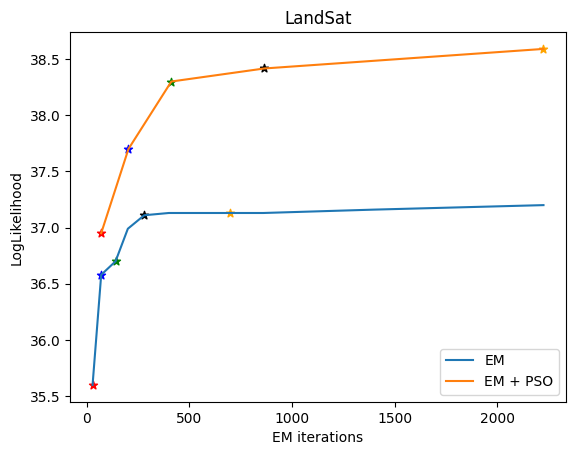

In [94]:
import matplotlib.pyplot as plt
colors = ['blue', 'green', 'black', 'red', 'orange']
plt.plot(np.sort([item[0] for item in exp_res_seg_em]), np.sort([item[1] for item in exp_res_seg_em]), label='EM')
plt.plot(np.sort([item[0] for item in exp_res_seg_pso.values()]), np.sort([item[1] for item in exp_res_seg_pso.values()]), label='EM + PSO')

plt.legend()
plt.ylabel("LogLikelihood")
plt.xlabel("EM iterations")

plt.title('LandSat')

for i, (key, value) in enumerate(exp_res_seg_pso.items()):
    exp_res_seg_pso[key]
    plt.scatter(exp_res_seg_pso[key][0], exp_res_seg_pso[key][1], marker='*', c=colors[i])
    plt.scatter(exp_res_dict[key][0], exp_res_dict[key][1], marker='*', c=colors[i])



Text(0.5, 0, 'EM iterations')

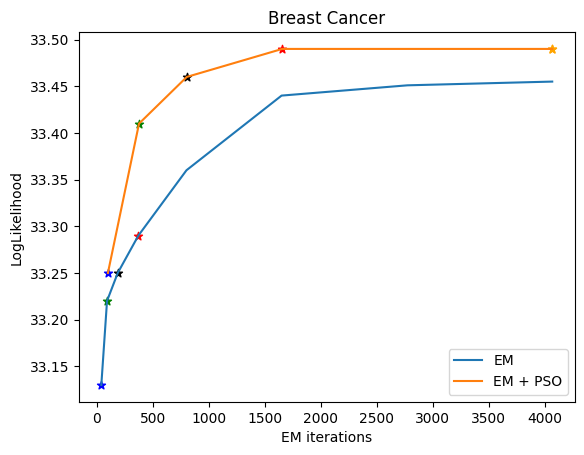

In [23]:
import matplotlib.pyplot as plt

exp_res_bc_pso = {2: (98, 33.25), 5: (376, 33.41), 10: (803, 33.46), 20: (1656.0, 33.49), 50: (4069, 33.49)}

exp_res_bc_em_dict = {2: (39, 33.13), 5: (90, 33.22), 10: (186, 33.25), 20: (370, 33.29), 50: (4069, 33.49)}

exp_res_bc_em = [(39, 33.13), (90, 33.22),(186, 33.25), (370, 33.29), (800, 33.36), (1650, 33.44), (2775, 33.451),  (4069, 33.455)]

colors = ['blue', 'green', 'black', 'red', 'orange']
plt.plot(np.sort([item[0] for item in exp_res_bc_em]), np.sort([item[1] for item in exp_res_bc_em]), label='EM')
plt.plot(np.sort([item[0] for item in exp_res_bc_pso.values()]), np.sort([item[1] for item in exp_res_bc_pso.values()]), label='EM + PSO')

for i, (key, value) in enumerate(exp_res_bc_pso.items()):
    exp_res_seg_pso[key]
    plt.scatter(exp_res_bc_pso[key][0], exp_res_bc_pso[key][1], marker='*', c=colors[i])
    plt.scatter(exp_res_bc_em_dict[key][0], exp_res_bc_em_dict[key][1], marker='*', c=colors[i])
    
plt.title('Breast Cancer')
plt.legend()
plt.ylabel("LogLikelihood")
plt.xlabel("EM iterations")
